In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kickstarter-projects/ks-projects-201801.csv
/kaggle/input/kickstarter-projects/ks-projects-201612.csv


In [2]:

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, recall_score, make_scorer, plot_confusion_matrix, confusion_matrix, accuracy_score
from scipy.stats import uniform

In [4]:
import plotly.express as px
def plot_histogram(dataframe, column, color: ['Discrete feature', '`None` if you only look at single continuous feature'], bins, title,width,height):
    figure = px.histogram(
                          dataframe,
                          column,
                          color=color,
                          nbins=bins,
                          title=title,
                          width=width,
                          height=height
                          )
    figure.show()

In [5]:
df = pd.read_csv('/kaggle/input/kickstarter-projects/ks-projects-201801.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


## The data set is quite large, so we will explore the random sample (10k). After we explore the sample and fit the models on it, we will retrain the models on the whole dataset (using the same features and transformations)

In [6]:
df = df.sample(10000, random_state=42).reset_index().drop('index', axis=1)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1576537356,Deko,Hardware,Technology,USD,2015-10-24,70000.0,2015-09-24 03:12:52,1888.0,failed,41,US,1888.00,1888.00,70000.00
1,675907016,"Westside BJ's: The Gluten-Free, Organic Food T...",Food Trucks,Food,USD,2015-02-01,250000.0,2015-01-02 20:55:07,1466.0,failed,9,US,1466.00,1466.00,250000.00
2,361890770,Crepe Diem Food Truck,Food,Food,USD,2014-01-17,30000.0,2013-12-18 03:26:04,5723.0,failed,90,US,5723.00,5723.00,30000.00
3,1225211551,Season's End - A horror novel ready for public...,Fiction,Publishing,GBP,2016-11-23,5500.0,2016-10-24 15:44:36,25.0,failed,2,GB,23.24,31.09,6839.01
4,2122944289,Colorado City Arizona Restaurant (Canceled),Restaurants,Food,USD,2015-05-13,30000.0,2015-03-14 05:18:34,100.0,canceled,3,US,100.00,100.00,30000.00


From what I understood, usd pledged is supposed to represent the amount that has already beeen pledged (in USD). Furthemore, pledged is supposed to represent the amount that has already pledged in the currency that is specified in the column currency. Therefore, it seems that all entries with value USD in the column currency must have same value in both pledged and usd pledged. Let's check it


In [7]:

df[(df['pledged'] != df['usd pledged']) & (df['currency'] == 'USD')].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
20,902381674,An Other Earth: Art & Science in the Arctic Ci...,Conceptual Art,Art,USD,2016-10-09,3000.0,2016-09-09 05:39:23,3081.0,successful,32,US,171.0,3081.0,3000.0
27,1725572740,Kids with Rare Genetic Conditions (A Photo Book),Photobooks,Photography,USD,2016-07-24,25000.0,2016-06-24 14:21:20,25367.0,successful,201,US,9703.0,25367.0,25000.0
28,373266567,I Found Jesus! A Seek & Discover Book,Children's Books,Publishing,USD,2017-05-04,10000.0,2017-04-04 08:01:03,10792.0,successful,148,US,855.0,10792.0,10000.0
31,210390595,"One Dress, Endless Possibilities",Fashion,Fashion,USD,2017-04-14,5000.0,2017-03-15 13:00:44,5675.0,successful,47,US,1685.0,5675.0,5000.0
38,2009589991,Cultural Collective,Spaces,Dance,USD,2017-04-07,5000.0,2017-02-21 00:39:26,865.0,failed,13,US,0.0,865.0,5000.0


In [8]:
# From the table above, we see that there is discrepancy between pledged and usd_pledged 
# (for entries that have USD in the column currency). Let's run the same test for features pledged and usd_pledged_real

df[(df['pledged'] != df['usd_pledged_real']) & (df['currency'] == 'USD')]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real


In [9]:
# We see that there is no discrepancy. It seems that usd_pledged may contain some incorrect inputs (and on the top of that, it is likely that usd pledged and usd_pledged_real represent the same feature). For now, we remove usd pledged.

df.drop(['usd pledged'],axis=1,inplace=True)

In [10]:
# Based on the data given, we want to predict whether the project will fail or succeed. Hence state will be our label. Let's check the distribution

df['state'].value_counts()

failed        5123
successful    3602
canceled      1058
undefined      101
live            63
suspended       53
Name: state, dtype: int64

In [11]:
# We will merge failed with suspendeded and canceled

# Furthermore, we will remove entries with live and undefined

#First we remove all the entries where state = undefined OR state = live

undef = df[df['state'] == 'undefined'].index
live = df[df['state'] == 'live'].index

df.drop(undef,axis=0,inplace=True)
df.drop(live,axis=0,inplace=True)


df['state'] = df['state'].map({'successful': 'successful',
                               'failed': 'failed',
                               'canceled': 'failed',
                                'suspended': 'failed'})

In [12]:
df['state'].value_counts()

failed        6234
successful    3602
Name: state, dtype: int64

In [13]:
df['state'].isnull().sum()

0

In [14]:
# Now let's look at the features
# Feature: usd_goal_real

suc_plus_fail = df['usd_goal_real'].describe().astype(int)
suc_plus_fail.name = 'All projects'


success = df[df['state'] =='successful']['usd_goal_real'].describe().astype(int)
success.name = 'Successful projects'


fail = df[df['state'] =='failed']['usd_goal_real'].describe().astype(int)
fail.name = 'Failed projects'



pd.concat([suc_plus_fail, success, fail],axis=1)

,All projects,Successful projects,Failed projects
count,9836,3602,6234
mean,47754,8930,70187
std,1380696,18027,1733899
min,1,1,1
25%,2000,1460,2851
50%,5555,3855,7724
75%,15838,10000,22000
max,100000000,400000,100000000


From the table above we see that the distribution for the feature usd_goal_real differs quite starkly between failed and successful projects. Notably, failed projects tend to set way larger goal (which is shown by higher mean and WAY higher standard deviation).

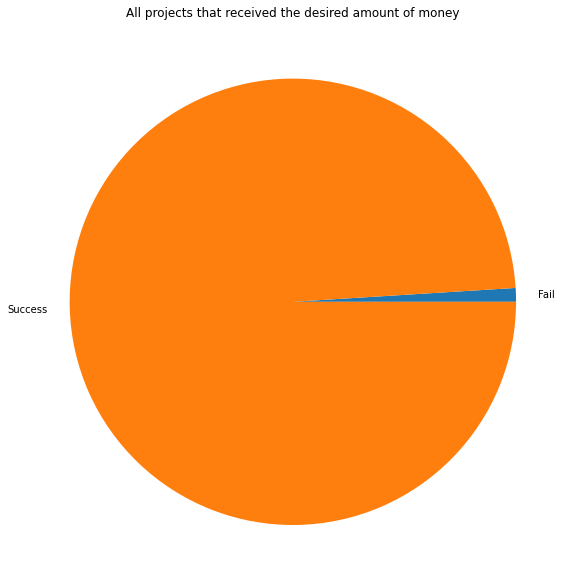

In [15]:
A = df[df['usd_goal_real'] - df['usd_pledged_real'] <= 0]
A2= pd.Series([A[A['state'] == 'failed'].count()[0], A[A['state'] == 'successful'].count()[0]],index=['Fail','Success'])
plt.figure(figsize=(10,15))
plt.pie(A2.values,labels=A2.index)
plt.title('All projects that received the desired amount of money')
plt.show()

We see that ALMOST ALL projects that reached the financial goal (i.e usd_goal_real - usd_pledged_real = 0) SUCCEEDED (3602 out of 3638). So it seems that the differece between usd_goal_real and usd_pledged_real might be a good predictor. Hence we create one more feature, namely goal-minus-pledged

In [16]:
df['Goal_minus_pledged'] = df['usd_goal_real'] - df['usd_pledged_real']

In [17]:
# Feature: country
df['country'].value_counts()

US      7710
GB       891
CA       393
AU       192
DE       108
IT        76
FR        72
ES        63
NL        55
NZ        49
MX        46
SE        41
IE        27
BE        22
DK        22
CH        17
NO        13
HK        12
AT        11
SG        10
N,0"       4
JP         1
LU         1
Name: country, dtype: int64

In [18]:
crosst = pd.crosstab(df['country'],df['state'])
crosst['% of succ. projects'] = crosst['successful']/crosst.sum(axis=1)
crosst.sort_values(by=['% of succ. projects'],inplace=True,ascending=False)
crosst.head(10)

state,failed,successful,% of succ. projects
country,,,
SG,3,7,0.700000
"N,0""",2,2,0.500000
US,4779,2931,0.380156
GB,556,335,0.375982
FR,48,24,0.333333
NL,37,18,0.327273
CA,266,127,0.323155
NO,9,4,0.307692
NZ,35,14,0.285714


Projects initiated in the countries SG and N,0" (whatever it means) seem to be having the highest probability of success. However, since the sample is fairly small for those countries, we cannot say for sure whether it is just a random chance or there is some other reason that may explain why projects from SG and N,0" seem to be more successful

In [19]:
# Feature: backers
df['backers'].describe().astype(int)

count     9836
mean       117
std       1149
min          0
25%          2
50%         12
75%         59
max      63758
Name: backers, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


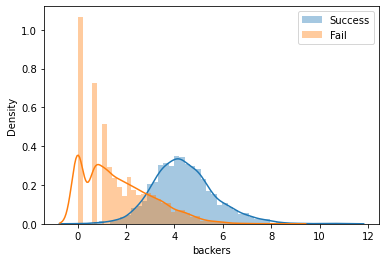

In [20]:
sns.distplot(np.log(df[df['state'] == 'successful']['backers']+1), label='Success')
sns.distplot(np.log(df[df['state'] == 'failed']['backers']+1), label='Fail')
plt.legend()
plt.show()

The pattern is quite clear: the more backers there are, the more chances of the project being successful.

In [21]:
# Feature: main_category
ccc = df['main_category'].value_counts()
px.pie(ccc, #DataFrame or Series
       names=ccc.index #Labels
       ,values=ccc.values, #Values (Count)
       title='Distribution of the main category')

In [22]:
B = pd.crosstab(df['main_category'],df['state'])
B['% of success'] = B['successful']/B.sum(axis=1)
B.sort_values(by='% of success', ascending=False,inplace=True)
B

state,failed,successful,% of success
main_category,,,
Dance,38,73,0.657658
Theater,120,170,0.586207
Comics,125,147,0.540441
Music,674,648,0.490166
Art,450,307,0.405548
Film & Video,1026,652,0.388558
Games,566,352,0.383442
Design,484,265,0.353805
Publishing,669,348,0.342183


In [23]:
px.bar(B, x=B.index, y='% of success',
       title='Proportion of successful projects for each category')

The main_category also seems to be a good predictor. Notably, 60% of the projects with the main_category valued dance are sucessful.

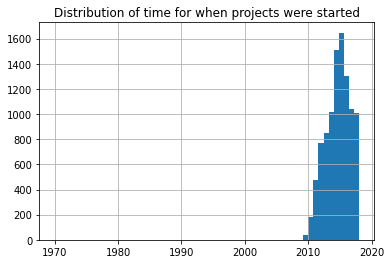

In [24]:
pd.to_datetime(df['launched']).hist(bins=60)
plt.title("Distribution of time for when projects were started")
plt.show()

In [25]:
time = pd.to_datetime(df['launched'])
time[time < pd.to_datetime('2010/01/01')].sort_values().head(3)

6688   1970-01-01 01:00:00
8356   2009-04-27 14:10:39
4111   2009-05-24 01:51:23
Name: launched, dtype: datetime64[ns]

In [26]:
df[pd.to_datetime(df['launched']) < pd.to_datetime('2000/01/01')]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,Goal_minus_pledged
6688,462917959,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,0.0,failed,0,US,0.0,500.0,500.0


In [27]:
# We see that most projects are launched after 2010. However, there is one outlier, namely one project launched in 1970. We will remove it.
#Remove the outlier to make the visualizations easier.
df1 = df.drop([6688],axis=0)
df1[df1['ID'] == 462917959]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,Goal_minus_pledged


In [28]:
df1['launched'] = pd.to_datetime(df1['launched'])
df1['launched'].min()

Timestamp('2009-04-27 14:10:39')

We want to look at the distribution of the launched (using histogram). Furthermore, we might want to use it as a feature when training model. However, as things stand, we can't do it. launched is of type datetime, but we need numeric type. Hence we will do some transformation first. First note that the earliest date is 2009-04-27. So we will create a new feature, days from 2008 to launch, where each value represents the NUMBER of days from 2008/01/01 to the date of the launch of the project. (note that 2008/01/01 is arbitrary, we could've chosen any date). The main motivation behind the transformation is that this way we can convert type datetime into numeric WITHOUT losing any important information (which could've been lost if we used another approaches (for example for each datetime entry just extract year). The only disadvantage of our approach is that we slightly lose interpretability.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



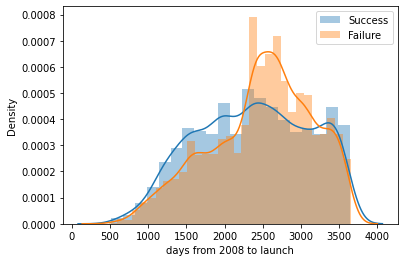

In [29]:
df1['days from 2008 to launch'] = (df1['launched'] - pd.to_datetime('2008/01/01')).apply(lambda x: x.days)
sns.distplot(df1[df1['state'] == 'successful']['days from 2008 to launch'], label='Success')
sns.distplot(df1[df1['state'] == 'failed']['days from 2008 to launch'], label='Failure')
plt.legend()

We see that the distributions of the launch times of the successful and failed projects do differ.

Let's see how the difference between time of the launch and the deadline affects the success rate

In [30]:
df1['Deadline-launch'] = (pd.to_datetime(df1['deadline']) - pd.to_datetime(df1['launched'])).apply(lambda x: x.days)
df1['Deadline-launch'].describe()

count    9835.000000
mean       32.906253
std        12.585512
min         0.000000
25%        29.000000
50%        29.000000
75%        35.000000
max        90.000000
Name: Deadline-launch, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



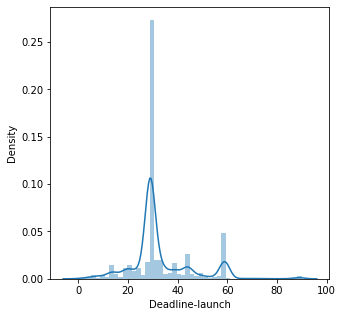

In [31]:
plt.figure(figsize=(5,5))
sns.distplot(df1['Deadline-launch'])
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



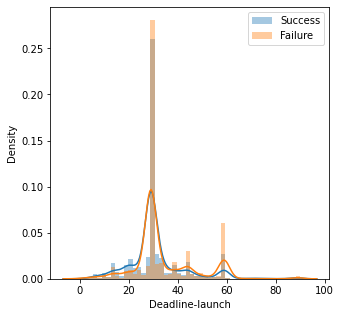

In [32]:
plt.figure(figsize=(5,5))
sns.distplot(df1[df1['state'] == 'successful']['Deadline-launch'], label='Success')
sns.distplot(df1[df1['state'] == 'failed']['Deadline-launch'], label='Failure')
plt.legend()
plt.show()

In [33]:
# We see that the distributions are rouhgly the same.

df.drop([6688],axis=0,inplace=True)
df['days from 2008 to launch'] = (pd.to_datetime(df['launched']) - pd.to_datetime('2008/01/01')).apply(lambda x: x.days)
df.head(1)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,Goal_minus_pledged,days from 2008 to launch
0,1576537356,Deko,Hardware,Technology,USD,2015-10-24,70000.0,2015-09-24 03:12:52,1888.0,failed,41,US,1888.0,70000.0,68112.0,2823


We will be using following features:

main_category

backers

usd_goal_real

Goal_minus_pledged (Synthetic feature derived after obtaining difference between amount that has been set as a GOAL and the amount that has already been pledged)

days from 2008 to launch (Synthetic feature derived after SUBTRACTING 2008/01/01 from each entry in the feature launched)

In [34]:
X = df[['main_category', 'backers', 'usd_goal_real','Goal_minus_pledged', 'days from 2008 to launch']]
X = pd.get_dummies(X) #One-hot encode `main_category`
y = df['state']
X.head()

,backers,usd_goal_real,Goal_minus_pledged,days from 2008 to launch,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,41,70000.00,68112.00,2823,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,9,250000.00,248534.00,2558,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,90,30000.00,24277.00,2178,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2,6839.01,6807.92,3219,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,3,30000.00,29900.00,2629,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [35]:
# Scaling continuous features
#Transform `backers`

thr = X['backers'].mean() + X['backers'].std()*3 
X['backers'] = X['backers'].apply(lambda x: x if x <= thr else thr+100)
X['backers'] = np.log(X['backers']+1)


#Transform `usd_goal_real`
thr = X['usd_goal_real'].mean() + X['usd_goal_real'].std()*3
clip_value = int(X[X['usd_goal_real'] <= thr]['usd_goal_real'].max() + 100 )
X['usd_goal_real'] = np.log(X['usd_goal_real'].apply(lambda x: x if x <= thr else clip_value))

#Transform `Goal-minus-pledged' (firstly by clipping), then robustly scaling AFTER splitting into train test

up_thr = X['Goal_minus_pledged'].quantile(0.95)
down_thr = X['Goal_minus_pledged'].quantile(0.03) 

def transform_gmp(x):
    if down_thr <= x <= up_thr:
        return x
    elif x < down_thr:
        return int(down_thr-100)
    elif x > up_thr:
        return int(up_thr+100)
X['Goal_minus_pledged'] = X['Goal_minus_pledged'].apply(transform_gmp) 

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=11)

days_scale = StandardScaler()
X_train['days from 2008 to launch'] = days_scale.fit_transform(X_train['days from 2008 to launch'].values.reshape(-1,1))
X_test['days from 2008 to launch'] = days_scale.transform(X_test['days from 2008 to launch'].values.reshape(-1,1))


diff_scale = RobustScaler() #Goal_minus_pledged
X_train['Goal_minus_pledged'] = diff_scale.fit_transform(X_train['Goal_minus_pledged'].values.reshape(-1,1))
X_test['Goal_minus_pledged'] = diff_scale.transform(X_test['Goal_minus_pledged'].values.reshape(-1,1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

              precision    recall  f1-score   support

      failed       0.90      0.86      0.88      1557
  successful       0.77      0.83      0.80       902

    accuracy                           0.85      2459
   macro avg       0.83      0.84      0.84      2459
weighted avg       0.85      0.85      0.85      2459



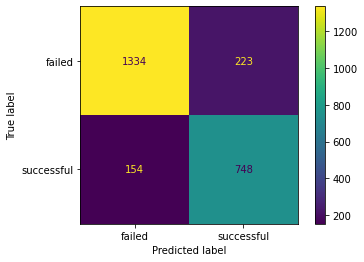

In [37]:
# Naive Bayes (sample)
#Naive Bayes
nb_clf = GaussianNB().fit(X_train,y_train)
print(classification_report(y_true=y_test, y_pred=nb_clf.predict(X_test)))
plot_confusion_matrix(nb_clf, X_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              precision    recall  f1-score   support

      failed       0.99      0.98      0.98      1557
  successful       0.96      0.98      0.97       902

    accuracy                           0.98      2459
   macro avg       0.97      0.98      0.97      2459
weighted avg       0.98      0.98      0.98      2459



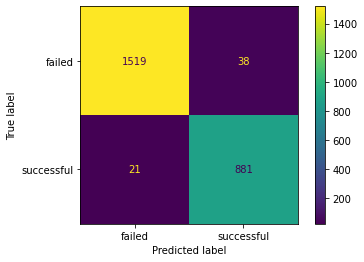

In [38]:
# Logistic (sample)
log_random_state = None
log_clf = LogisticRegression(random_state=log_random_state).fit(X_train, y_train)
print(classification_report(y_true=y_test, y_pred=log_clf.predict(X_test)))
plot_confusion_matrix(log_clf, X_test, y_test)

Best estimator: KNeighborsClassifier(n_neighbors=18)
              precision    recall  f1-score   support

      failed       0.96      0.96      0.96      1557
  successful       0.93      0.94      0.93       902

    accuracy                           0.95      2459
   macro avg       0.95      0.95      0.95      2459
weighted avg       0.95      0.95      0.95      2459



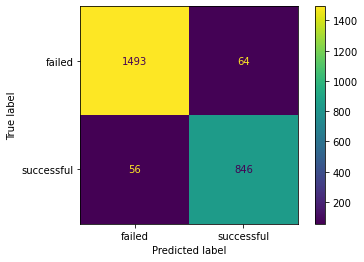

In [39]:
# KNN (sample)
MIN = 1 #Min number of neighbors
MAX = 30 #Max number of neighbors
knn_estimator = KNeighborsClassifier()
knn_clf = GridSearchCV(knn_estimator,
                       {'n_neighbors': range(MIN,MAX+1)}
                       ,scoring='accuracy').fit(X_train, y_train)
print(f"Best estimator: {knn_clf.best_estimator_}")
print(classification_report(y_true=y_test, y_pred=knn_clf.predict(X_test)))
plot_confusion_matrix(knn_clf, X_test, y_test)